In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import *

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso
from sklearn.inspection import permutation_importance

import xgboost

In [4]:
df_train = pd.read_csv('house-prices-advanced-regression-techniques/train.csv')
df_test  = pd.read_csv('house-prices-advanced-regression-techniques/test.csv')

In [5]:
test_id = df_test['Id'].tolist() # for submitting to kaggle

In [6]:
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

### Логарифмируем Y

/var/folders/l_/s4xzmc2x339gwwc9tb7m1h3m0000gn/T/ipykernel_70238/294359312.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_train['SalePrice'])


<Axes: xlabel='SalePrice', ylabel='Density'>

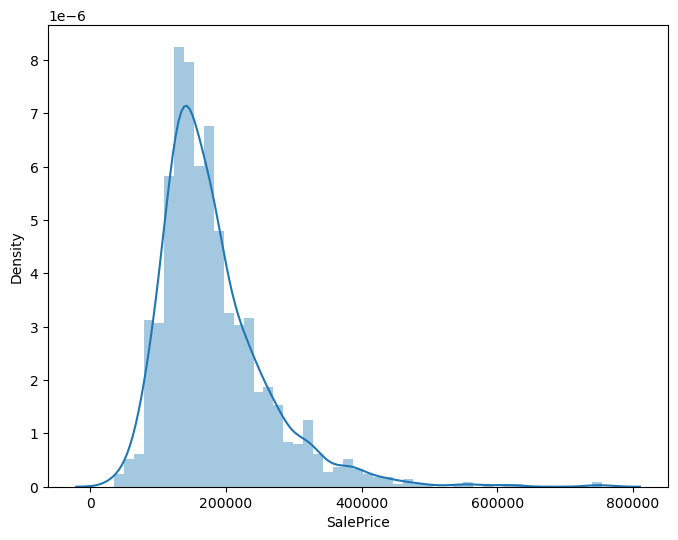

In [8]:
# гистограмма
f, ax = plt.subplots(figsize=(8, 6))
sns.distplot(df_train['SalePrice'])

In [9]:
# Рассчитываем асимметрию и эксцесс
print("Ассиметрия: %f" % df_train['SalePrice'].skew())
print("Эксцесс: %f" % df_train['SalePrice'].kurt())

Ассиметрия: 1.882876
Эксцесс: 6.536282


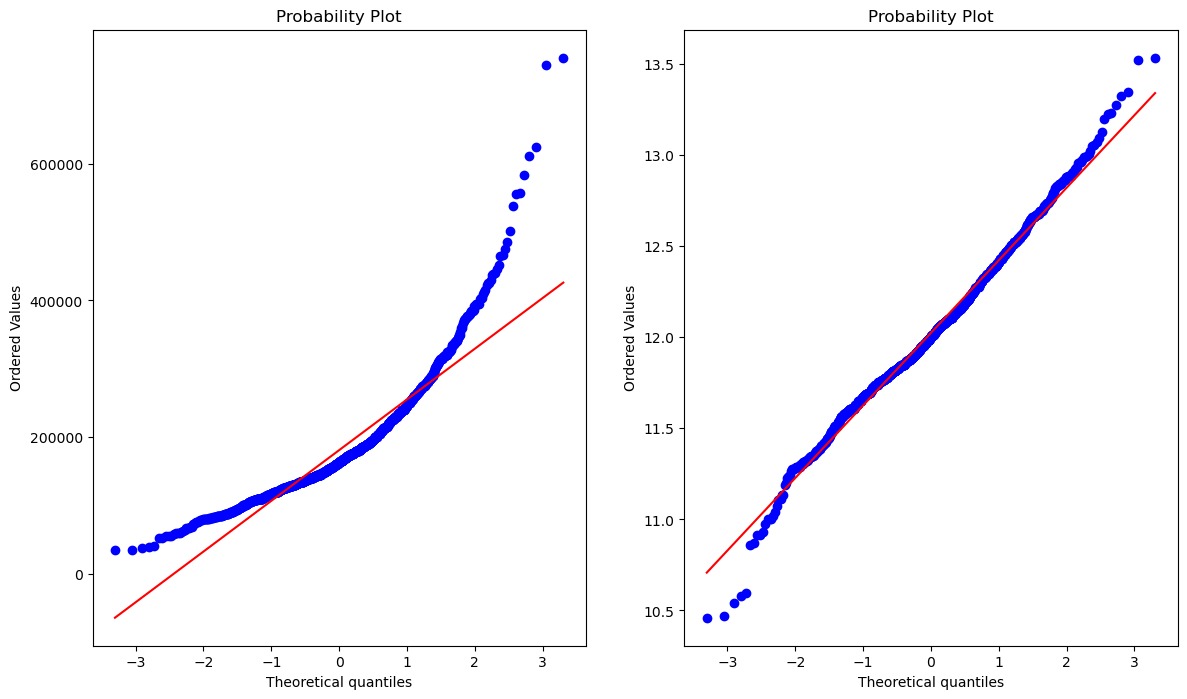

In [10]:
from scipy import stats 

fig = plt.figure(figsize = (14,8))

# Распределение на необработанных данных
fig.add_subplot(1,2,1)
res = stats.probplot(df_train['SalePrice'], plot=plt)

# Распределение при условии, что мы прологарифмировали 'SalePrice'
fig.add_subplot(1,2,2)
res = stats.probplot(np.log1p(df_train['SalePrice']), plot=plt)

In [11]:
df_train['SalePrice'] = np.log1p(df_train['SalePrice'])
y = df_train['SalePrice']

In [12]:
df_train.drop('SalePrice', axis=1, inplace=True)

### Обработка NaN

Text(0.5, 1.0, 'Features with the highest percentage of Nan values')

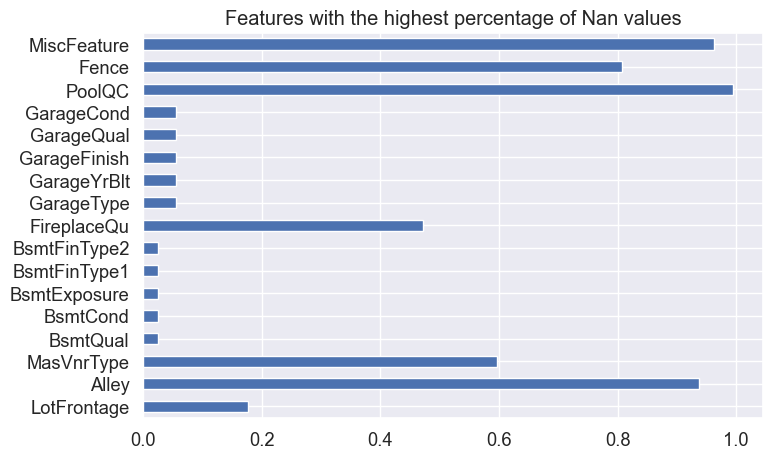

In [13]:
df_train.isnull().sum().sort_values(ascending=False).head(20)

col_nan = df_train.isna().sum() / df_train.shape[0]
plt.figure(figsize=(8, 5))
sns.set(font_scale=1.2)
col_nan[col_nan > 0.01].plot(kind = "barh")
plt.title("Features with the highest percentage of Nan values")

In [14]:
drop_out_columns = df_train.columns[[inx for inx, i in enumerate(col_nan >= 0.70) if i==True]]
data_df = df_train.drop(drop_out_columns, axis=1)
test_df= df_test.drop(drop_out_columns, axis=1)

In [15]:
data_df.isnull().sum().sort_values(ascending=False).head(20)

MasVnrType      872
FireplaceQu     690
LotFrontage     259
GarageCond       81
GarageType       81
GarageYrBlt      81
GarageFinish     81
GarageQual       81
BsmtFinType2     38
BsmtExposure     38
BsmtFinType1     37
BsmtCond         37
BsmtQual         37
MasVnrArea        8
Electrical        1
PavedDrive        0
PoolArea          0
LowQualFinSF      0
GrLivArea         0
BsmtFullBath      0
dtype: int64

In [16]:
data_df = data_df.drop(["Street", "Utilities",'Id'], axis=1)
test_df = test_df.drop(["Street", "Utilities",'Id'], axis=1)

In [17]:
df = pd.concat([data_df,test_df],axis=0)    # конкатенация дата фреймов тестового и основного
print("Shape of df: ", df.shape)

Shape of df:  (2919, 73)


### Разделяем фичи на категориальные и дискретные

In [18]:
numerical_features=[]
for feature in df:
    if df[feature].dtype!='O' and feature!= 'SalePrice':
        numerical_features.append(feature)

object_features= []
for feature in df:
    if df[feature].dtype =='object' and feature!= 'SalePrice':
        object_features.append(feature)


discrete_variables=[]
for feature in numerical_features:
    if len(df[feature].unique())<=25 and feature != 'SalePrice':
        discrete_variables.append(feature)

# print(np.array(discrete_variables))
# print(np.array(object_features))
# obj_list = df.select_dtypes(include=['object']).columns.tolist()
#print(np.array(numerical_features))

In [19]:
# для графиков

#for feature in discrete_variables:
     #df.groupby(feature)['SalePrice'].mean().plot.bar()
     #plt.xlabel(feature)
     #plt.ylabel('Sale Price')
     #plt.title(feature +' vs '+' SalePrice')
     #plt.show()

In [20]:
df.isnull().sum().sort_values(ascending=False).head(20)

MasVnrType      1766
FireplaceQu     1420
LotFrontage      486
GarageQual       159
GarageCond       159
GarageYrBlt      159
GarageFinish     159
GarageType       157
BsmtCond          82
BsmtExposure      82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrArea        23
MSZoning           4
Functional         2
BsmtFullBath       2
BsmtHalfBath       2
GarageCars         1
KitchenQual        1
dtype: int64

In [21]:
# Функция для просмотра пропущенных данных

def missingValuesInfo(df):
    total = df.isnull().sum().sort_values(ascending = False)
    percent = round(df.isnull().sum().sort_values(ascending = False) / len(df)*100, 2)
    temp = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return temp.loc[(temp['Total'] > 0)]

missingValuesInfo(df)

,Total,Percent
MasVnrType,1766,60.50
FireplaceQu,1420,48.65
LotFrontage,486,16.65
GarageQual,159,5.45
GarageCond,159,5.45
GarageYrBlt,159,5.45
GarageFinish,159,5.45
GarageType,157,5.38
BsmtCond,82,2.81
BsmtExposure,82,2.81


In [22]:
# Разбираемся с пропущенными данными
# Числовые значения отбираем через принадлежность к формату ['int64', 'float64']
# Категориальные значения отбираем через принадлежность к формату ["object"]

def HandleMissingValues(df):
    num_cols = [cname for cname in df.columns if df[cname].dtype in ['int64', 'float64']]
    cat_cols = [cname for cname in df.columns if df[cname].dtype == "object"]
    values = {}
    for a in cat_cols:
        values[a] = 'UNKNOWN'

    for a in num_cols:
        values[a] = df[a].median()
        
    df.fillna(value=values, inplace=True)
    
    
HandleMissingValues(df)
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Reg,Lvl,Inside,Gtl,CollgCr,Norm,...,61,0,0,0,0,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Reg,Lvl,FR2,Gtl,Veenker,Feedr,...,0,0,0,0,0,0,5,2007,WD,Normal
2,60,RL,68.0,11250,IR1,Lvl,Inside,Gtl,CollgCr,Norm,...,42,0,0,0,0,0,9,2008,WD,Normal
3,70,RL,60.0,9550,IR1,Lvl,Corner,Gtl,Crawfor,Norm,...,35,272,0,0,0,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,IR1,Lvl,FR2,Gtl,NoRidge,Norm,...,84,0,0,0,0,0,12,2008,WD,Normal


In [23]:
df.isnull().sum().sort_values(ascending=False).head(20)

MSSubClass      0
CentralAir      0
FireplaceQu     0
Fireplaces      0
Functional      0
TotRmsAbvGrd    0
KitchenQual     0
KitchenAbvGr    0
BedroomAbvGr    0
HalfBath        0
FullBath        0
BsmtHalfBath    0
BsmtFullBath    0
GrLivArea       0
LowQualFinSF    0
2ndFlrSF        0
1stFlrSF        0
GarageType      0
GarageYrBlt     0
GarageFinish    0
dtype: int64

In [24]:
# Проверим
df.isnull().sum().sum()

0

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2919 entries, 0 to 1458
Data columns (total 73 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     2919 non-null   int64  
 1   MSZoning       2919 non-null   object 
 2   LotFrontage    2919 non-null   float64
 3   LotArea        2919 non-null   int64  
 4   LotShape       2919 non-null   object 
 5   LandContour    2919 non-null   object 
 6   LotConfig      2919 non-null   object 
 7   LandSlope      2919 non-null   object 
 8   Neighborhood   2919 non-null   object 
 9   Condition1     2919 non-null   object 
 10  Condition2     2919 non-null   object 
 11  BldgType       2919 non-null   object 
 12  HouseStyle     2919 non-null   object 
 13  OverallQual    2919 non-null   int64  
 14  OverallCond    2919 non-null   int64  
 15  YearBuilt      2919 non-null   int64  
 16  YearRemodAdd   2919 non-null   int64  
 17  RoofStyle      2919 non-null   object 
 18  RoofMatl     

In [26]:
df.isnull().sum().sort_values(ascending=False).head(20)

MSSubClass      0
CentralAir      0
FireplaceQu     0
Fireplaces      0
Functional      0
TotRmsAbvGrd    0
KitchenQual     0
KitchenAbvGr    0
BedroomAbvGr    0
HalfBath        0
FullBath        0
BsmtHalfBath    0
BsmtFullBath    0
GrLivArea       0
LowQualFinSF    0
2ndFlrSF        0
1stFlrSF        0
GarageType      0
GarageYrBlt     0
GarageFinish    0
dtype: int64

In [27]:
# Разбираемся с категориальными признаками

def getObjectColumnsList(df):
    return [cname for cname in df.columns if df[cname].dtype == "object"]

def PerformOneHotEncoding(df, columnsToEncode):
    return pd.get_dummies(df, columns=columnsToEncode)

cat_cols = getObjectColumnsList(df)
df = PerformOneHotEncoding(df, cat_cols)
df.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_New,SaleType_Oth,SaleType_UNKNOWN,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60,65.0,8450,7,5,2003,2003,196.0,706.0,0.0,...,False,False,False,True,False,False,False,False,True,False
1,20,80.0,9600,6,8,1976,1976,0.0,978.0,0.0,...,False,False,False,True,False,False,False,False,True,False
2,60,68.0,11250,7,5,2001,2002,162.0,486.0,0.0,...,False,False,False,True,False,False,False,False,True,False
3,70,60.0,9550,7,5,1915,1970,0.0,216.0,0.0,...,False,False,False,True,True,False,False,False,False,False
4,60,84.0,14260,8,5,2000,2000,350.0,655.0,0.0,...,False,False,False,True,False,False,False,False,True,False


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2919 entries, 0 to 1458
Columns: 288 entries, MSSubClass to SaleCondition_Partial
dtypes: bool(252), float64(11), int64(25)
memory usage: 1.5 MB


In [29]:
discrete_variables

['MSSubClass',
 'OverallQual',
 'OverallCond',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageCars',
 'PoolArea',
 'MoSold',
 'YrSold']

### Feature Engineering на завтра- объединяем фичи


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2919 entries, 0 to 1458
Columns: 288 entries, MSSubClass to SaleCondition_Partial
dtypes: bool(252), float64(11), int64(25)
memory usage: 1.5 MB


In [31]:
df["TotalArea"] = df["GrLivArea"] + df["TotalBsmtSF"]
df["TotalBaths"] = df["FullBath"] + df["BsmtFullBath"] + 0.5*(df["HalfBath"]+ df["BsmtHalfBath"])
df["TotalPorch"] = df["OpenPorchSF"] + df["EnclosedPorch"] + df["3SsnPorch"] + df["ScreenPorch"]

In [32]:
df.drop(['GrLivArea','TotalBsmtSF','FullBath','BsmtFullBath','HalfBath','BsmtHalfBath','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch'], axis =1)

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,TotalArea,TotalBaths,TotalPorch
0,60,65.0,8450,7,5,2003,2003,196.0,706.0,0.0,...,True,False,False,False,False,True,False,2566.0,3.5,61
1,20,80.0,9600,6,8,1976,1976,0.0,978.0,0.0,...,True,False,False,False,False,True,False,2524.0,2.5,0
2,60,68.0,11250,7,5,2001,2002,162.0,486.0,0.0,...,True,False,False,False,False,True,False,2706.0,3.5,42
3,70,60.0,9550,7,5,1915,1970,0.0,216.0,0.0,...,True,True,False,False,False,False,False,2473.0,2.0,307
4,60,84.0,14260,8,5,2000,2000,350.0,655.0,0.0,...,True,False,False,False,False,True,False,3343.0,3.5,84
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,160,21.0,1936,4,7,1970,1970,0.0,0.0,0.0,...,True,False,False,False,False,True,False,1638.0,1.5,0
1455,160,21.0,1894,4,5,1970,1970,0.0,252.0,0.0,...,True,True,False,False,False,False,False,1638.0,1.5,24
1456,20,160.0,20000,5,7,1960,1996,0.0,1224.0,0.0,...,True,True,False,False,False,False,False,2448.0,2.0,0
1457,85,62.0,10441,5,5,1992,1992,0.0,337.0,0.0,...,True,False,False,False,False,True,False,1882.0,1.5,32


In [33]:
# Scaling
cols = df.select_dtypes(np.number).columns
df[cols] = RobustScaler().fit_transform(df[cols])

In [34]:
# ss = StandardScaler()
# df = ss.fit_transform(df)
# # df

### Encoding

In [35]:
# df = pd.get_dummies(df) #Get_dummies function to encode data

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2919 entries, 0 to 1458
Columns: 291 entries, MSSubClass to TotalPorch
dtypes: bool(252), float64(39)
memory usage: 1.6 MB


### Матрица корреляции

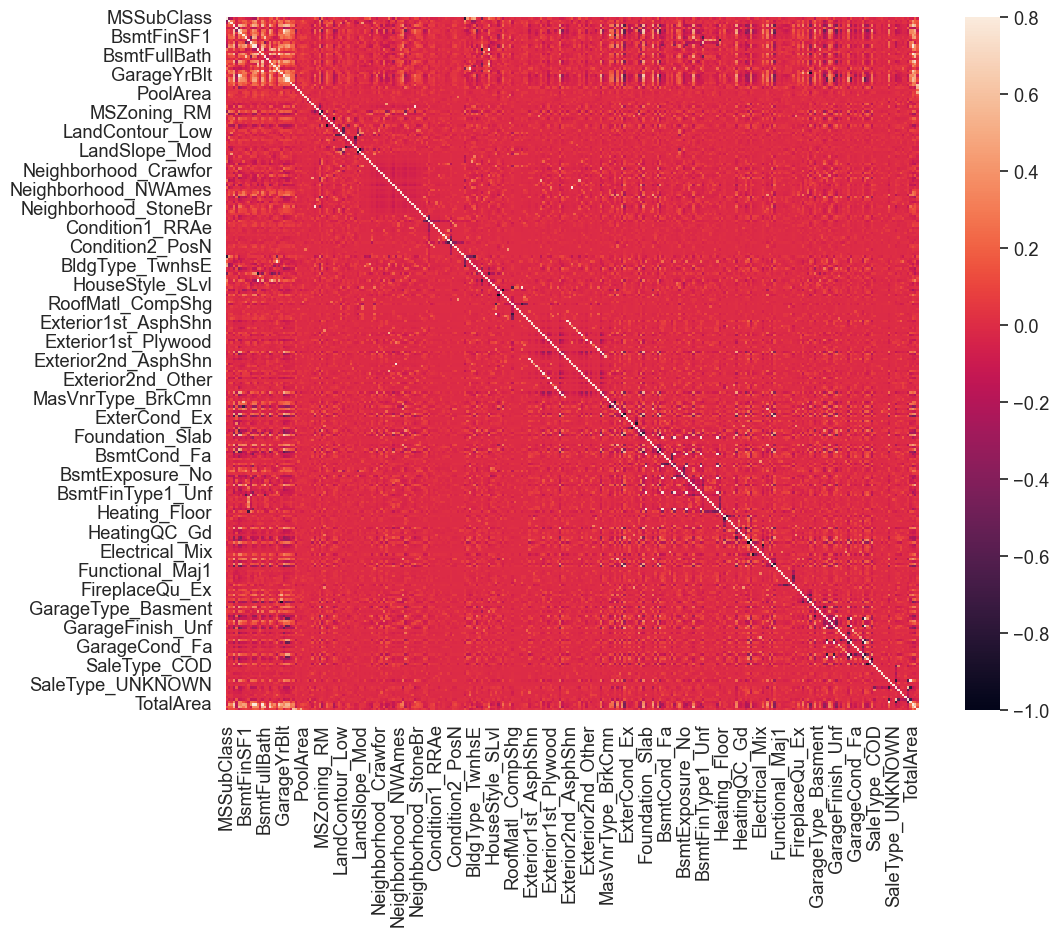

In [37]:
corrmat = df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);


# k = 10 # количество коррелирующих признаков, которое мы хотим увидеть
# cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
# cm = np.corrcoef(data_inc[cols].values.T)
# sns.set(font_scale=1.25)
# hm = sns.heatmap(cm, cbar=True, annot=True, square=True, 
#                  fmt='.2f', annot_kws={'size': 10}, 
#                  yticklabels=cols.values, xticklabels=cols.values)
# plt.show()

In [38]:
#df_train['SalePrice'] = np.log1p(df_train['SalePrice'])   ##смотри начало
#y = df_train['SalePrice']
df.shape


(2919, 291)

In [39]:
train_preprocessed = df.iloc[:len(df_train),:]
test_preprocessed = df.iloc[len(train_preprocessed):,:]
print(len(test_preprocessed) == len(df_test))

True


In [40]:
test_preprocessed

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,TotalArea,TotalBaths,TotalPorch
0,-0.6,0.666667,0.530059,-0.5,1.0,-0.252632,-0.820513,0.000000,0.135744,144.0,...,True,False,False,False,False,True,False,-0.680444,-1.0,0.514706
1,-0.6,0.722222,1.176442,0.0,1.0,-0.315789,-0.897436,0.660550,0.756480,0.0,...,True,False,False,False,False,True,False,0.206653,-0.5,-0.102941
2,0.2,0.333333,1.069648,-0.5,0.0,0.505263,0.128205,0.000000,0.576398,0.0,...,True,False,False,False,False,True,False,0.104839,0.5,-0.117647
3,0.2,0.555556,0.128299,0.0,1.0,0.526316,0.128205,0.122324,0.318554,0.0,...,True,False,False,False,False,True,False,0.077621,0.5,-0.102941
4,1.4,-1.388889,-1.086999,1.0,0.0,0.400000,-0.025641,0.000000,-0.143929,0.0,...,True,False,False,False,False,True,False,0.107863,0.0,1.294118
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2.2,-2.611111,-1.836999,-1.0,2.0,-0.063158,-0.589744,0.000000,-0.502729,0.0,...,True,False,False,False,False,True,False,-0.821573,-0.5,-0.367647
1455,2.2,-2.611111,-1.847263,-1.0,0.0,-0.063158,-0.589744,0.000000,-0.158936,0.0,...,True,True,False,False,False,False,False,-0.821573,-0.5,-0.191176
1456,-0.6,5.111111,2.577468,-0.5,2.0,-0.273684,0.076923,0.000000,1.167121,0.0,...,True,True,False,False,False,False,False,-0.005040,0.0,-0.367647
1457,0.7,-0.333333,0.241447,-0.5,0.0,0.400000,-0.025641,0.000000,-0.042974,0.0,...,True,False,False,False,False,True,False,-0.575605,-0.5,-0.132353


In [41]:
X_train = train_preprocessed


In [42]:
x_train, x_valid, y_train, y_valid = train_test_split(X_train, y.to_numpy(),
                                                      test_size=0.2)

In [43]:
x_train.shape, y_train.shape

((1168, 291), (1168,))

### Models

In [44]:
lasso = Lasso(alpha= 0.1)
lasso.fit(x_train, y_train)

selected_columns = pd.Series(dict(zip(x_train.columns, lasso.coef_))).sort_values(key=lambda x: abs(x), ascending=False)
print(selected_columns.head(10))
selected_columns = selected_columns[10:]
# lasso = Lasso(alpha=0.8)
# lasso.fit(x_train, y_train)

# coef_series = pd.Series(dict(zip(x_train.columns, lasso.coef_)))
# sorted_columns = coef_series.abs().sort_values(ascending=False).index.tolist()

# selected_columns = sorted_columns[55:]

TotalArea        0.129885
OverallQual      0.118776
TotalBaths       0.024762
GarageArea       0.024322
LotArea          0.003928
EnclosedPorch   -0.000527
3SsnPorch        0.000456
ScreenPorch      0.000420
LowQualFinSF    -0.000235
MiscVal         -0.000008
dtype: float64


In [45]:
from sklearn.decomposition import PCA


pca = PCA(10)
pca.fit(df)
pca.explained_variance_ratio_.sum()


0.9999380044588949

In [46]:
explained_variance = pca.explained_variance_ratio_
explained_variance


array([8.89488743e-01, 7.91372356e-02, 1.16668221e-02, 8.55995084e-03,
       5.84920200e-03, 3.45427589e-03, 1.74785655e-03, 1.87928694e-05,
       9.84495968e-06, 5.28028818e-06])

In [47]:
lr = LinearRegression()
lr.fit(x_train, y_train)

y_train_pred = lr.predict(x_train)
mse_train = mean_squared_error(y_train, y_train_pred)
print("MSE on train:", mse_train)

# print('Linear Regression')
# print('RMSE :', np.sqrt(mean_squared_error(y_valid, y_train_pred)))

MSE on train: 0.008915851820365321


In [48]:
from sklearn.ensemble import RandomForestRegressor


rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=3,
    oob_score=True,
    random_state=1
)
rf.fit(x_train, y_train)

y_train_pred = rf.predict(x_train)
mse_train = mean_squared_error(y_train, y_train_pred)
print("MSE on train:", mse_train)

MSE on train: 0.029579828951841036


In [49]:
from sklearn.ensemble import GradientBoostingRegressor
clf = GradientBoostingRegressor(
    criterion= 'friedman_mse',
    learning_rate=0.1,
    n_estimators=100,
    max_depth=3,
    min_samples_leaf=2,
    min_samples_split=8,
    loss='huber'
)

clf.fit(x_train, y_train)
train_preds = clf.predict(x_train)
test_preds = clf.predict(x_valid)

train_mse = mean_squared_error(y_train, train_preds)
test_mse = mean_squared_error(y_valid, test_preds)

print(f"Train MSE: {train_mse}")
print(f"Test MSE: {test_mse}")

Train MSE: 0.0076930559241382744
Test MSE: 0.014392797353351878


In [164]:
from sklearn.model_selection import GridSearchCV

In [165]:
clf = GradientBoostingRegressor(
    learning_rate=0.1,
    n_estimators=40,
    max_depth=2
)
parametrs = {
  'loss': ['squared_error' , 'absolute_error', 'huber', 'quantile'],
  "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
  "min_samples_split": np.linspace(0.1, 0.5, 12),
  "min_samples_leaf": np.linspace(0.1, 0.5, 12),
  "max_depth":[2, 3],
  "max_features":["log2","sqrt"],
  "criterion": ["friedman_mse",  "mae"],
  "subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
  "n_estimators":[10]
}

#grid_clf = GridSearchCV(clf, parametrs, cv=5)
##grid_clf.fit(x_train, y_train)
from sklearn.model_selection import GridSearchCV

In [166]:
# grid_clf.best_params_

In [167]:
# # Make necessary imports
# from catboost import CatBoostRegressor, Pool, cv
# from sklearn.metrics import accuracy_score

# #To show plots
# from ipywidgets import interact  
# import ipywidgets as widgets

In [168]:
# from catboost import CatBoostRegressor


# #categorical_features_indices = np.where(x_train.dtypes != np.float)[
# #

# modelcat = CatBoostRegressor(iterations=100, loss_function='RMSE')

# # train the model
# modelcat.fit(    
# #    train_data,  #   Tried this with pooled data defined above
#      x_train,
#      y_train,
#      #cat_features=categorical_features_indices,
#      eval_set=(x_valid, y_valid),
#      verbose=False,
#      plot=False
# )



# modelcat.fit(x_train, y_train)
# train_preds = modelcat.predict(x_train)
# test_preds = modelcat.predict(x_valid)

# train_mse = mean_squared_error(y_train, train_preds)
# test_mse = mean_squared_error(y_valid, test_preds)

# print(f"Train MSE: {train_mse}")
# print(f"Test MSE: {test_mse}")

In [169]:
# # make the prediction using the resulting model
# y_pred = modelcat.predict(x_train)
# x_train.shape
# y_pred.shape

#catboosting 

In [170]:
# from catboost import CatBoostRegressor
# cat = CatBoostRegressor()


# cat.fit(x_train, y_train)

# from catboost import Pool, cv
# params = {"iterations": 100,
#           "depth": 2,
#           "loss_function": "RMSE",
#           "verbose": False}
# cv_dataset = Pool(data=x_train,         #выполняю кросс валидацию
#                   label=y_train)
# scores = cv(cv_dataset,
#             params,
#             fold_count=2, 
#             plot="True")

In [171]:
# #выполняю грид серч
# grid = {'learning_rate': [0.03, 0.1],
#         'depth': [4, 6, 10],
#         'l2_leaf_reg': [1, 3, 5, 7, 9]}

# grid_search_result = cat.grid_search(grid, X=x_train, y=y_train, plot=True)

In [50]:
submit = pd.DataFrame()
submit['Id'] = test_id
submit['SalePrice'] = clf.predict(test_preprocessed)

In [51]:
submit

,Id,SalePrice
0,1461,11.718758
1,1462,12.003699
2,1463,12.178011
3,1464,12.152527
4,1465,12.154021
...,...,...
1454,2915,11.287646
1455,2916,11.366127
1456,2917,11.968014
1457,2918,11.708563


In [52]:
submit['SalePrice'] = np.expm1(submit['SalePrice'])

In [57]:
submit.to_csv('/Users/irina/workspace/ds_bootcamp/ds-phase-1/kaggle_house/house-prices-advanced-regression-techniques/submission_9.csv',index=False)

### Streamleat